## Updates for multiclass dataloader

In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/nyc_subway_turnstile_sample.csv",index_col='time')
df.shape

(26208, 16)

In [3]:
def preprocess_data(df, forecast_lead=15, train_test_split=0.8):
    features = list(df.columns)
    #target = f"{target_feature}_lead_{forecast_lead}"

    #df[target] = df[target_feature].shift(-forecast_lead)
    #df = df.iloc[:-forecast_lead]

    test_start = int(len(df) * train_test_split)

    df_train = df.iloc[:test_start].copy()
    df_test = df.iloc[test_start:].copy()

    #target_mean = df_train[target].mean()
    #target_stdev = df_train[target].std()

    for c in df_train.columns:
        mean = df_train[c].mean()
        stdev = df_train[c].std()

        df_train[c] = (df_train[c] - mean) / stdev
        df_test[c] = (df_test[c] - mean) / stdev

    return df_train, df_test, features

In [29]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, features, sequence_length=5, forecast_lead=15):
        self.features = features
        self.forecast_lead = forecast_lead
        self.sequence_length = sequence_length
        self.X = torch.tensor(dataframe[features].iloc[:-self.forecast_lead,:].values).float()
        self.y = torch.tensor(dataframe[features].iloc[self.forecast_lead:,:].values).float()
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        if i > self.sequence_length -1:
            i_start = i - self.sequence_length +1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i+1), :]
            x = torch.cat((padding, x), 0)
        #y = self.X[i + self.forecast_lead]
        return x, self.y[i]

In [30]:
SEQUENCE_LENGTH = 10
FORECAST_LEAD = 5
BATCH_SIZE = 32

df_train, df_test, features = preprocess_data(df,
                                              forecast_lead=FORECAST_LEAD,
                                              train_test_split=0.8
                                             )

In [31]:
df_train.shape

(20966, 16)

In [32]:
train_dataset = SequenceDataset(df_train, 
                                features,
                                sequence_length=SEQUENCE_LENGTH,
                                forecast_lead=FORECAST_LEAD)

test_dataset = SequenceDataset(df_test, 
                               features,
                               sequence_length=SEQUENCE_LENGTH,
                               forecast_lead=FORECAST_LEAD)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
class LSTMRegression(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers=1,dropout=0):
        super().__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=self.dropout
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=self.num_features)
        
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        _,(hn,_) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])#.flatten()
        return out

In [35]:
model = LSTMRegression(
        num_features=len(features), 
        hidden_units=2,
        num_layers=1,
        dropout=0
        )#.to(device=device)

In [36]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [37]:
def score_model(data_loader, model, loss_function, device=torch.device("mps")):
    num_batches = len(data_loader)
    total_loss = 0
    #model = model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            #X = X.to(device)
            #y = y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()
    avg_loss = total_loss/num_batches
    #print(f"Test loss: {avg_loss}")
    return avg_loss

In [38]:
test_score = score_model(test_loader, model, loss_function)

In [39]:
test_score

1.2401497887402047

In [40]:
def train_model(data_loader, model, loss_function, optimizer, device=torch.device("mps")):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        #X = X.to(device=device)
        #y = y.to(device=device)
        output = model(X)
        loss = loss_function(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/num_batches
    #print(f"Train loss: {avg_loss}")
    return avg_loss

In [41]:
num_epochs = 200
for ix_epoch in range(num_epochs):
    #logger.info(f"Epoch: {ix_epoch}")
    train_score = train_model(train_loader, model, loss_function, optimizer=optimizer)
    #tb.add_scalar("Train Loss", train_score, ix_epoch)
    #logger.info(f"Train score: {train_score}")
    test_score = score_model(test_loader, model, loss_function)
    #tb.add_scalar("Test Loss", test_score, ix_epoch)
    #logger.info(f"Test score: {test_score}")
    print(f"Epoch {ix_epoch} -- Train Loss: {train_score}; Test Loss: {test_score}")

Epoch 0 -- Train Loss: 1.1560491546988487; Test Loss: 1.1911349111213916
Epoch 1 -- Train Loss: 1.1153975924158968; Test Loss: 1.1596054467486172
Epoch 2 -- Train Loss: 1.0887024785596422; Test Loss: 1.1334890323441202
Epoch 3 -- Train Loss: 1.0667079242809516; Test Loss: 1.1095592546753767
Epoch 4 -- Train Loss: 1.0465166454271573; Test Loss: 1.0869777218961134
Epoch 5 -- Train Loss: 1.0257597447531979; Test Loss: 1.066022428252348
Epoch 6 -- Train Loss: 1.0082793016804428; Test Loss: 1.046036624872103
Epoch 7 -- Train Loss: 0.9885632090452241; Test Loss: 1.027096903905636
Epoch 8 -- Train Loss: 0.9730339356493659; Test Loss: 1.009263871646509
Epoch 9 -- Train Loss: 0.9566408120459173; Test Loss: 0.992390137438367
Epoch 10 -- Train Loss: 0.9403860784340196; Test Loss: 0.9767331161150118
Epoch 11 -- Train Loss: 0.9258125015511746; Test Loss: 0.9615398069343916
Epoch 12 -- Train Loss: 0.9090178475783366; Test Loss: 0.9466092522914816
Epoch 13 -- Train Loss: 0.8949549560684983; Test Loss

In [17]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

def get_predictions(data_loader,model, df_test, target):
    ystar_col = "Model Forecast"
    #df_train[ystar_col] = predict(train_eval_loader, model).numpy()
    df_test[ystar_col] = predict(data_loader, model).numpy()

    df_out = df_test[[target, ystar_col]]

    #for c in df_out.columns:
    #    df_out[c] = df_out[c] * target_stdev + target_mean
    
    return df_out

In [18]:
preds = predict(test_loader, model)

In [19]:
preds.shape

torch.Size([5227, 16])

In [20]:
def plot_predictions(df_preds):
    fig_dims = (40, 10)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.lineplot(data=df_preds,ax=ax)
    plt.show()

In [21]:
def get_predictions(data_loader, model, df_test):
    preds = predict(data_loader, model)
    df_preds = pd.DataFrame()
    df_preds['y_pred'] = preds[:,0]
    df_preds['y_true'] = [x for x in df_test.iloc[:-15,0]]
    return df_preds

In [25]:
df_preds = pd.DataFrame(preds)

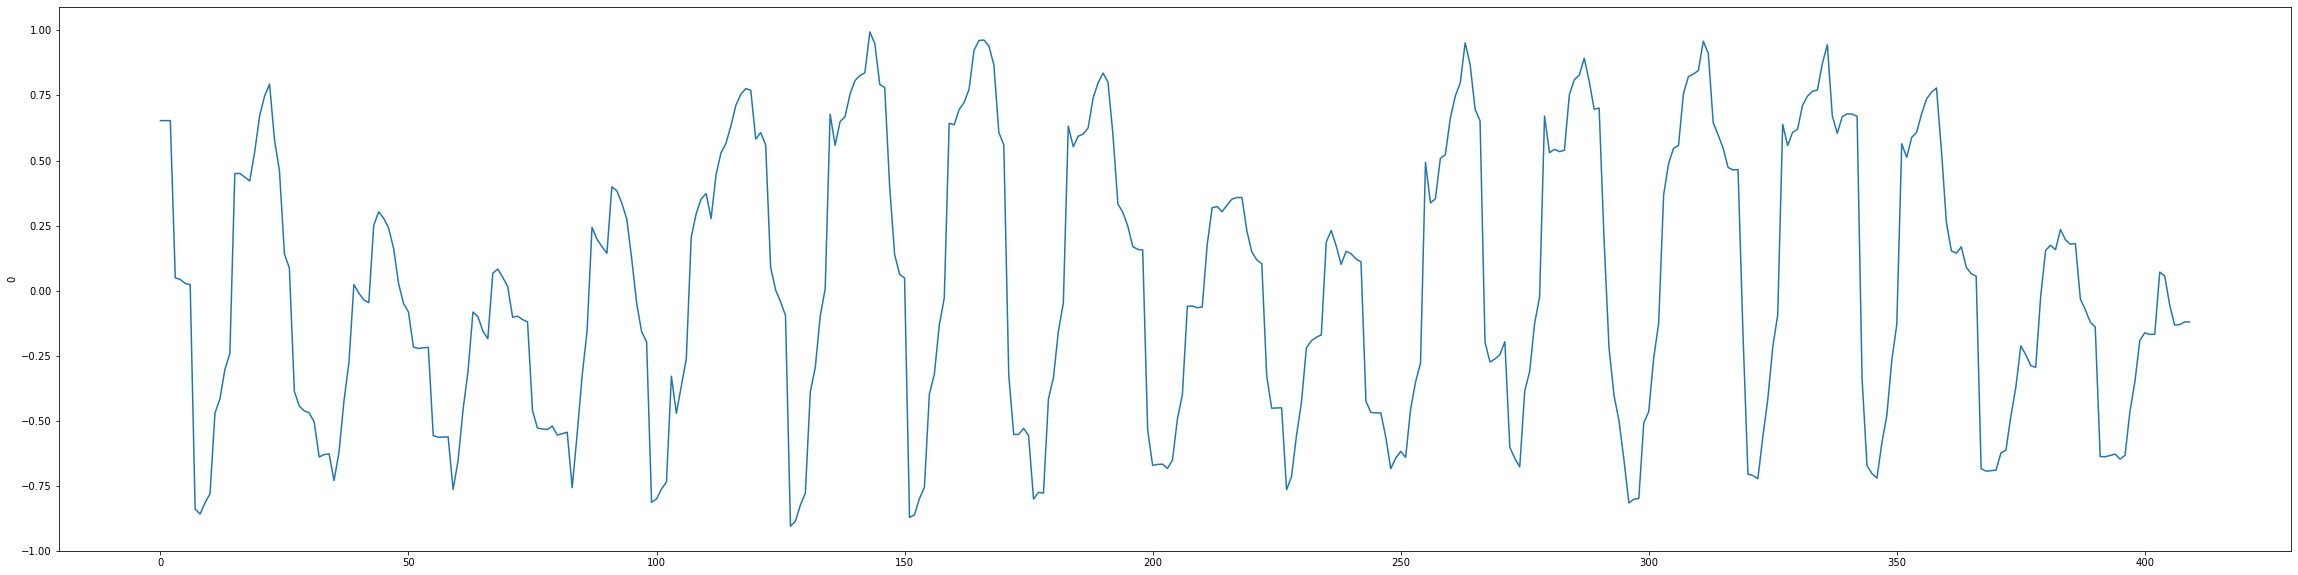

In [27]:
plot_predictions(df_preds[0].head(410))

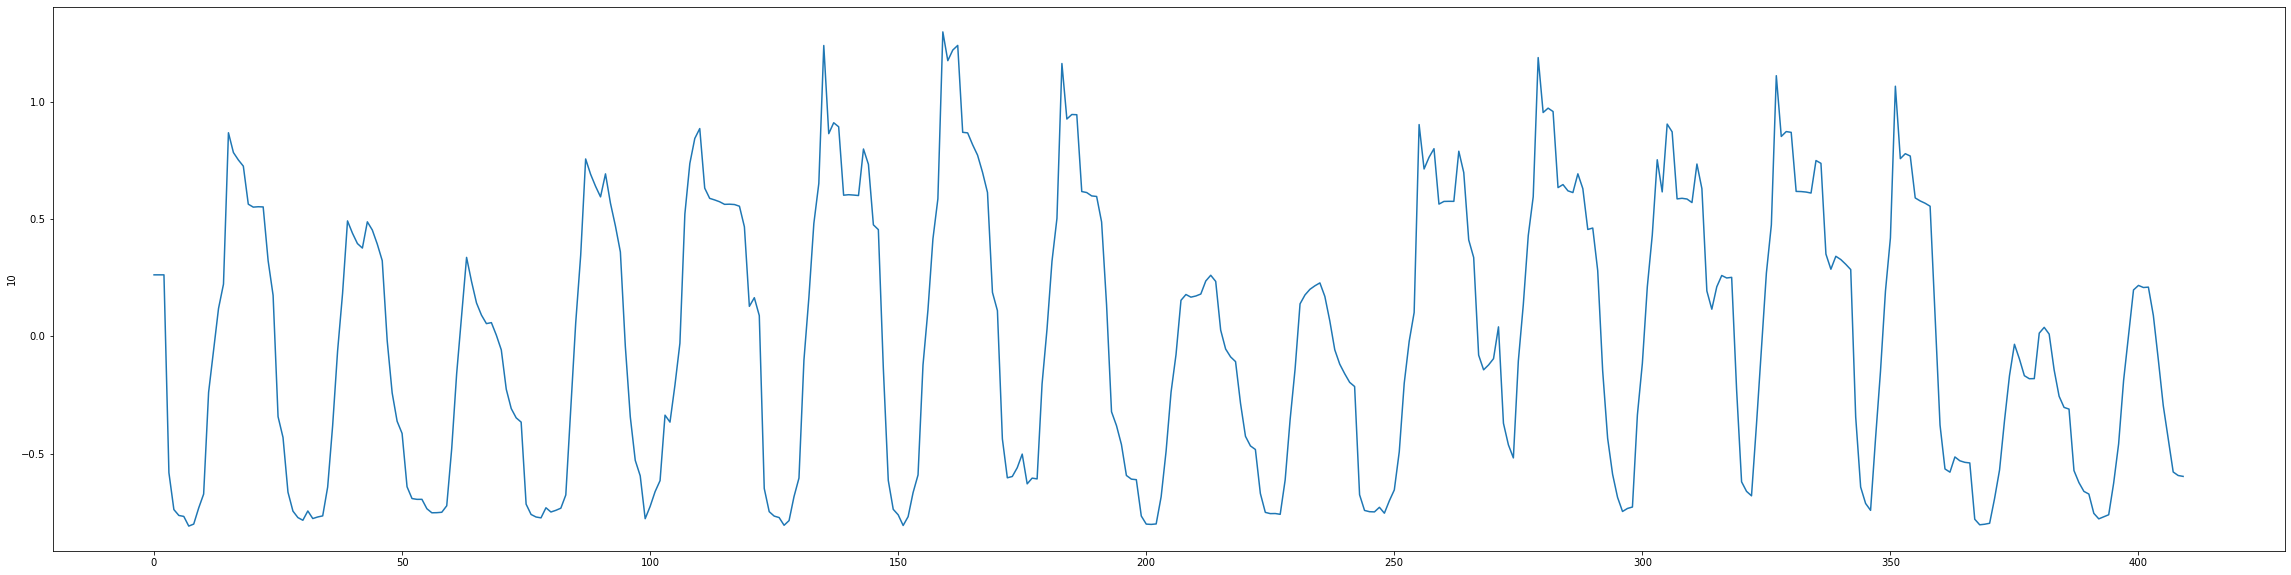

In [28]:
plot_predictions(df_preds[10].head(410))

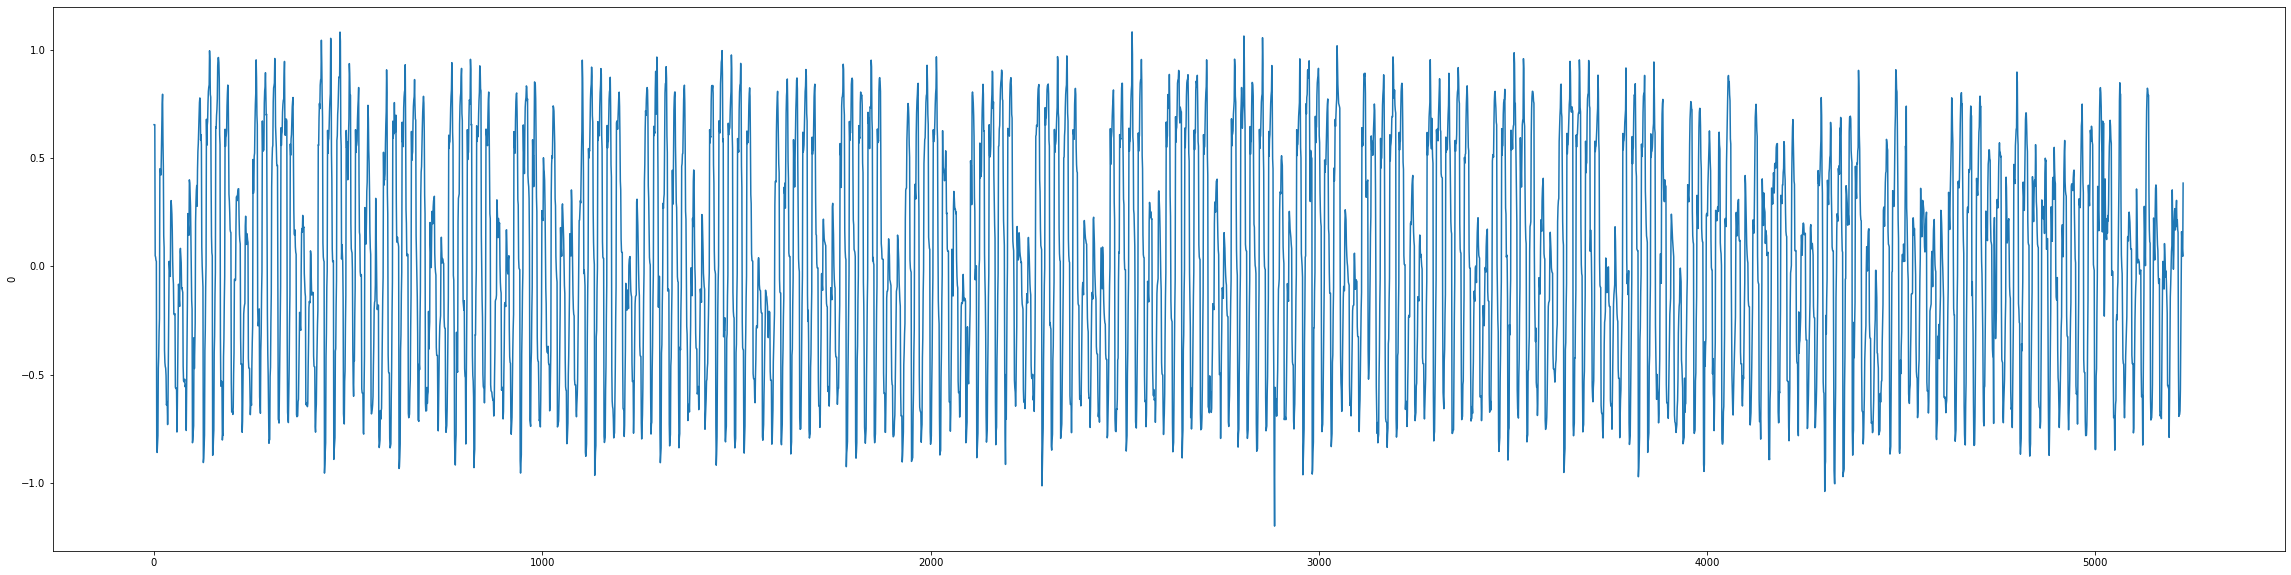

In [26]:
plot_predictions(df_preds[0])